# Fit Stochastic Block Model parameters

Fit the parameters `p_in` and `p_ou` of the stochastic block model graph generation algorithm to match the initial exponential growth of the Ebola epidemic from the literature.

---

Load libs.

In [1]:
%load_ext autoreload
%autoreload 2

Add the project base directory to the path

In [2]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import networkx as nx

from graph_generation import make_ebola_network
from dynamics import SIRDynamicalSystem

---

Define simulation parameters

In [57]:
sim_dict = {
    'total_time': 60.0,
    'trials_per_setting': 5
}
param_dict = {
     'beta':  1.0 / 15.3,  # Serial interval time (from literature)
#    'beta': 1.0,
    'gamma': 0.0,
     'delta': 1.0 / 11.4,  # Course of infection (from literature)
#    'delta': 2.0,
    'rho':   0.0,
    'eta':   0.0
}
cost_dict = {
    'Qlam': 1.0,
    'Qx': 1.0
}
baselines_dict = {
    'TR': 0.003,
    'MN': 0.0007,
    'LN': 0.0008,
    'LRSR': 22.807,
    'MCM': 22.807,
    'FL_info': {'N': None, 'max_u': None},
}

In [58]:
param_dict

{'beta': 0.06535947712418301,
 'gamma': 0.0,
 'delta': 0.08771929824561403,
 'rho': 0.0,
 'eta': 0.0}

Build propagation network

In [ ]:
# graph = nx.Graph()
# graph.add_edges_from([('6','1'), ('1', '2'), ('2', '3'), ('2', '4'), ('4', '5'), ('5', '1')])
# A = nx.adjacency_matrix(graph).toarray()

# n_nodes = 100
# A = np.ones((n_nodes, n_nodes))
# A[np.eye(n_nodes, dtype=bool)] = 0
# graph = nx.Graph(A)

# print(A)

# nx.draw_networkx(graph)
# plt.axis('off');

In [7]:
# Generate graph
p_in = 0.00075
graph = make_ebola_network(n_nodes=100000, p_in=p_in, p_out=p_in/5)
A = nx.adjacency_matrix(graph).toarray()

print(graph.number_of_nodes(), graph.number_of_edges())
print(list(map(len, nx.connected_components(graph))))

89828 170457
[89828]


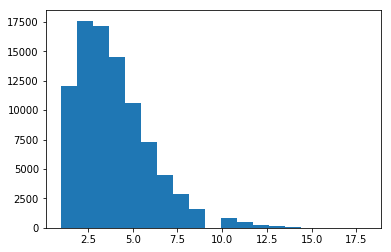

In [8]:
degree_sequence = [d for n, d in graph.degree()]
max_deg = max(degree_sequence)
plt.hist(degree_sequence, bins=max_deg+1);

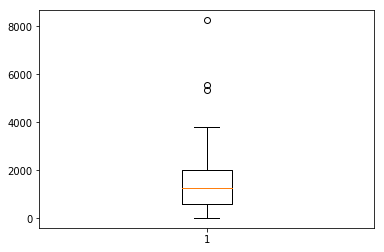

In [13]:
cluster_sizes = np.bincount([d['block'] for u,d in graph.nodes(data=True)])
plt.boxplot(cluster_sizes);

Extract seeds

In [59]:
def sample_seeds(n_seeds):
    # Load real data
    df = pd.read_csv('../data/ebola/rstb20160308_si_001_cleaned.csv')
    df = df.sort_values('infection_timestamp').iloc[:n_seeds]
    # Extract the seed disctricts
    seed_names = list(df['district'])
    # Extract district name for each node in the graph
    node_names = np.array([u for u, d in graph.nodes(data=True)])
    node_districts = np.array([d['district'] for u, d in graph.nodes(data=True)])
    # Get last infection time of seeds (this is time zero for the simulation)
    last_inf_time = df.iloc[-1].infection_timestamp
    # Init list of seed events
    init_event_list = list()
    for _, row in df.iterrows():
        inf_time = row['infection_timestamp']
        # Sample recovery time
        rec_time = inf_time + np.random.exponential(1./param_dict['delta']) - last_inf_time
        # Ignore seed if recovered before time zero
        if rec_time > 0:
            # Randomly sample one node for each seed in the corresponding district
            idx = np.random.choice(np.where(node_districts == row['district'])[0])
            node = node_names[idx]
            # Add infection event
            init_event_list.append([(node, 'inf', True), 0.0])  # Gets infection at the start of the epidemic
            # Add recovery event
#             init_event_list.append([(node, 'rec', False), rec_time])  # Artificial recovery
            print(f'Add seed {node} from district {row["district"]} - inf: {0.0}, rec: {rec_time} ')
    return init_event_list

Run simulations

In [60]:
from epidemics_helper import SimulationSIR

n_seeds = 10

res = list()
for i in range(50):
    print(f'=== {i+1:d}')
    init_event_list = sample_seeds(n_seeds)
    sir = SimulationSIR(graph, beta=param_dict['beta'], gamma=param_dict['delta'], verbose=True)
    sir.launch_epidemic(init_event_list=init_event_list, max_time=sim_dict['total_time'])
    res.append(sir)

=== 1
Add seed 19927 from district GUECKEDOU - inf: 0.0, rec: 0.8810652871916567 
Add seed 19753 from district GUECKEDOU - inf: 0.0, rec: 3.7974582435360134 
Add seed 20965 from district GUECKEDOU - inf: 0.0, rec: 4.135975726475486 
Add seed 20857 from district GUECKEDOU - inf: 0.0, rec: 7.1602499083489235 
Epidemic stopped after 60.00 days | 60.00 days elapsed | 98.9% susceptible, 0.5% infected, 0.5% recovered
=== 2
Add seed 98755 from district WESTERN - inf: 0.0, rec: 12.242481186124387 
Add seed 64432 from district TONKOLILI - inf: 0.0, rec: 14.20396141813189 
Add seed 22135 from district GUECKEDOU - inf: 0.0, rec: 5.284758642792426 
Add seed 19409 from district GUECKEDOU - inf: 0.0, rec: 52.53552703398003 
Add seed 19083 from district GUECKEDOU - inf: 0.0, rec: 8.741031890912026 
Add seed 19473 from district GUECKEDOU - inf: 0.0, rec: 0.4995612398618192 
Add seed 20161 from district GUECKEDOU - inf: 0.0, rec: 7.845113423078978 
Epidemic stopped after 60.00 days | 60.00 days elapsed

Epidemic stopped after 60.00 days | 60.00 days elapsed | 95.5% susceptible, 2.2% infected, 2.3% recovered
=== 24
Add seed 20391 from district GUECKEDOU - inf: 0.0, rec: 8.321006211381977 
Add seed 20706 from district GUECKEDOU - inf: 0.0, rec: 18.838154739319528 
Add seed 21708 from district GUECKEDOU - inf: 0.0, rec: 12.317826960282297 
Add seed 21459 from district GUECKEDOU - inf: 0.0, rec: 7.042143933165136 
Epidemic stopped after 60.00 days | 60.00 days elapsed | 96.3% susceptible, 1.9% infected, 1.8% recovered
=== 25
Add seed 22242 from district GUECKEDOU - inf: 0.0, rec: 18.39136765920587 
Add seed 21964 from district GUECKEDOU - inf: 0.0, rec: 7.585964620753124 
Epidemic stopped after 60.00 days | 60.00 days elapsed | 99.0% susceptible, 0.5% infected, 0.5% recovered
=== 26
Add seed 21604 from district GUECKEDOU - inf: 0.0, rec: 1.8801706786939434 
Add seed 22124 from district GUECKEDOU - inf: 0.0, rec: 20.275997898976094 
Add seed 22136 from district GUECKEDOU - inf: 0.0, rec: 2

In [61]:
doubling_time_list = list()

for i, sir in enumerate(res):
    if np.sum(sir.inf_time < np.inf) < 20:
        # Epidemic died out before, ignore this simulation
        print(i, 'inf')
        continue
    else:
        doubling_time = 0.0
        while np.sum(sir.inf_time < doubling_time) < 20:
            doubling_time += 0.5
        doubling_time_list.append(doubling_time)
        print(i, doubling_time)

0 10.5
1 5.0
2 inf
3 18.0
4 11.5
5 12.0
6 inf
7 5.5
8 5.0
9 8.0
10 5.5
11 10.0
12 8.0
13 5.0
14 8.5
15 12.0
16 11.0
17 9.0
18 inf
19 11.5
20 15.0
21 8.5
22 10.0
23 8.0
24 19.5
25 5.5
26 12.0
27 11.0
28 17.0
29 18.5
30 17.5
31 9.5
32 10.5
33 35.5
34 35.5
35 6.5
36 13.0
37 inf
38 inf
39 10.5
40 8.5
41 8.5
42 14.0
43 14.0
44 11.5
45 10.0
46 3.0
47 8.0
48 13.5
49 10.5


In [64]:
np.mean(doubling_time_list)

11.577777777777778

In [65]:
min_idx = int(np.round(0.05 * len(doubling_time_list)))
max_idx = int(np.round(0.95 * len(doubling_time_list)))
sorted_doubling_time_list = sorted(doubling_time_list)
sorted_doubling_time_list[min_idx], sorted_doubling_time_list[max_idx]

(5.0, 35.5)

In [55]:
pd.DataFrame([(graph.node[sir.idx_to_node[idx]]['district'], sir.inf_time[idx]) for idx in np.argsort(sir.inf_time)])

,0,1
0,GUECKEDOU,0.000000
1,GUECKEDOU,0.000000
2,GUECKEDOU,0.000000
3,KONO,0.030319
4,GUECKEDOU,0.748285
5,GUECKEDOU,1.287845
6,KOINADUGU,1.613330
7,LOFA,4.522978
8,LOFA,5.938314
9,GUECKEDOU,6.109398


In [72]:
X_init = np.array(sir.inf_time == 0, dtype=int)
X_init.sum()

3

In [73]:
system = SIRDynamicalSystem(X_init, A, param_dict, cost_dict, debug=False, verbose=True, notebook=True)
data = system.simulate_policy('NO', baselines_dict, sim_dict, plot=False)

KeyboardInterrupt: 